In [4]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings

In [5]:
# Load dataset
df = pd.read_csv('../../data/player_game_statistics.csv')
display(df.columns)

Index(['stat_id', 'player_id', 'player_name', 'age', 'gender', 'country',
       'game_id', 'game_name', 'total_games_played', 'total_wins',
       'total_losses', 'total_moves', 'total_time_played_minutes', 'win_ratio',
       'rating', 'last_played'],
      dtype='object')

In [3]:
# Inspect the target column (game engagement duration)
print(df.head())

                                stat_id                             player_id  \
0  3407ea25-ba61-11ef-9d4e-00155d326b4e  d16771fa-ba60-11ef-9d4e-00155d326b4e   
1  3409a88e-ba61-11ef-9d4e-00155d326b4e  d133c41a-ba60-11ef-9d4e-00155d326b4e   
2  3409bca3-ba61-11ef-9d4e-00155d326b4e  d15034ff-ba60-11ef-9d4e-00155d326b4e   
3  340a17ca-ba61-11ef-9d4e-00155d326b4e  d15ee3cd-ba60-11ef-9d4e-00155d326b4e   
4  340a5066-ba61-11ef-9d4e-00155d326b4e  d1224a65-ba60-11ef-9d4e-00155d326b4e   

       player_name  age      gender country  \
0   David Gonzales   34      Female  Canada   
1     Joseph Davis   18      Female   Japan   
2  Isabella Martin   51  Non-Binary   Spain   
3   Michael Thomas   33  Non-Binary      UK   
4    Evelyn Thomas   18  Non-Binary  Brazil   

                                game_id   game_name  total_games_played  \
0  d0ac190e-ba60-11ef-9d4e-00155d326b4e  battleship                 170   
1  d0ac190e-ba60-11ef-9d4e-00155d326b4e  battleship                 148   
2  d0

In [4]:
# Engineer features
df['avg_session_duration'] = df['total_time_played_minutes'] / df['total_games_played']
df['win_rate'] = df['total_wins'] / df['total_games_played']
df['avg_moves_per_game'] = df['total_moves'] / df['total_games_played']

# Define target variable (predicted engagement time in minutes)
df['future_engagement'] = df['total_time_played_minutes'] * (1 + df['win_rate']) * (df['total_games_played'] / df['age'])

# Select features for model
features = ['avg_session_duration', 'win_rate', 'avg_moves_per_game',
           'total_games_played', 'age', 'total_time_played_minutes']


In [5]:
# Prepare features and target
X = df[features]
y = df['future_engagement']

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Initialize models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

In [9]:
# Define hyperparameter grids
param_grids = {
    'Linear': {},
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
}

In [10]:
# Train and evaluate models with GridSearchCV
results = {}
best_models = {}

print("Performing Hyperparameter Tuning...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create and fit GridSearchCV
    grid_search = GridSearchCV(
        model, 
        param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    # Use scaled features for all models
    grid_search.fit(X_train_scaled, y_train)
    
    # Store best model
    best_models[name] = grid_search.best_estimator_
    
    # Make predictions
    y_pred = grid_search.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store results
    results[name] = {
        'R2 Score': r2,
        'RMSE': rmse,
        'Best Parameters': grid_search.best_params_
    }

Performing Hyperparameter Tuning...

Training Linear...

Training Ridge...

Training Lasso...

Training RandomForest...

Training XGBoost...

Training SVR...

Training GradientBoosting...


In [11]:
# Print results
print("\nModel Performance Summary:")
print("-" * 60)
print(f"{'Model':<20} {'R² Score':<12} {'RMSE':<12} {'Best Parameters'}")
print("-" * 60)

best_r2 = 0
best_model = None

for name, metrics in results.items():
    print(f"{name:<20} {metrics['R2 Score']:>10.4f}  {metrics['RMSE']:>10.2f}  {metrics['Best Parameters']}")
    
    if metrics['R2 Score'] > best_r2:
        best_r2 = metrics['R2 Score']
        best_model = name

print("-" * 60)
print(f"\nBest Performing Model: {best_model}")
print(f"Best R² Score: {best_r2:.4f}")
print(f"Best RMSE: {results[best_model]['RMSE']:.2f}")


Model Performance Summary:
------------------------------------------------------------
Model                R² Score     RMSE         Best Parameters
------------------------------------------------------------
Linear                   0.8268     7326.85  {}
Ridge                    0.8257     7349.94  {'alpha': 10.0}
Lasso                    0.8267     7327.49  {'alpha': 10.0}
RandomForest             0.9769     2673.73  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost                  0.9769     2677.16  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
SVR                      0.3984    13653.77  {'C': 10, 'kernel': 'linear'}
GradientBoosting         0.9761     2721.20  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
------------------------------------------------------------

Best Performing Model: RandomForest
Best R² Score: 0.9769
Best RMSE: 2673.73


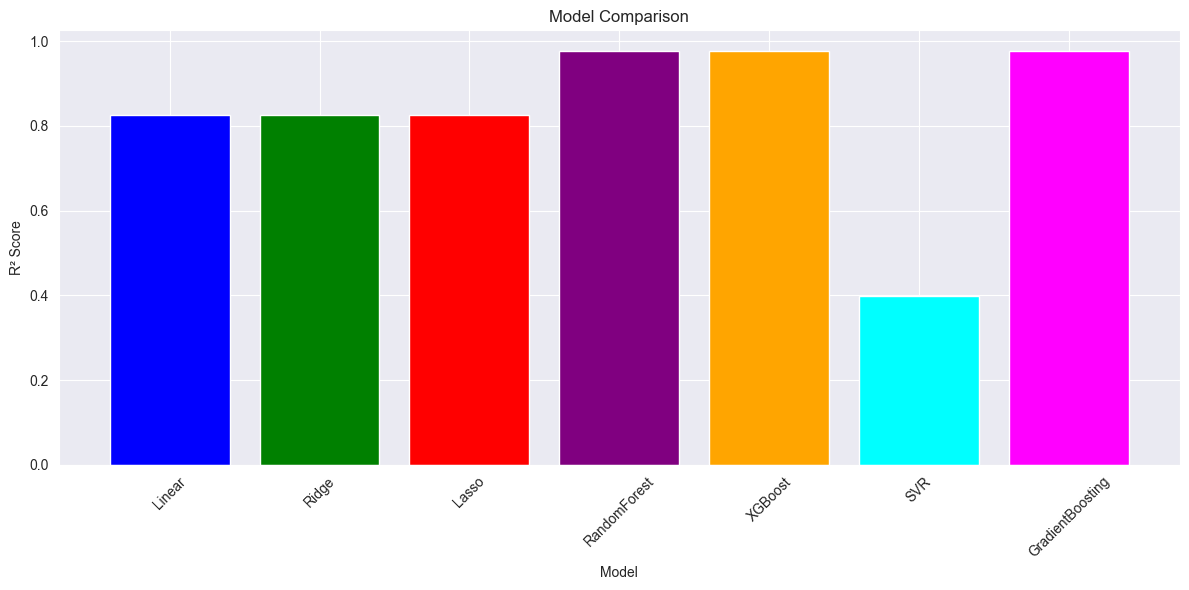

In [12]:
# Plot model comparison
plt.figure(figsize=(12, 6))
r2_scores = [metrics['R2 Score'] for metrics in results.values()]
model_names = list(results.keys())

plt.bar(model_names, r2_scores, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

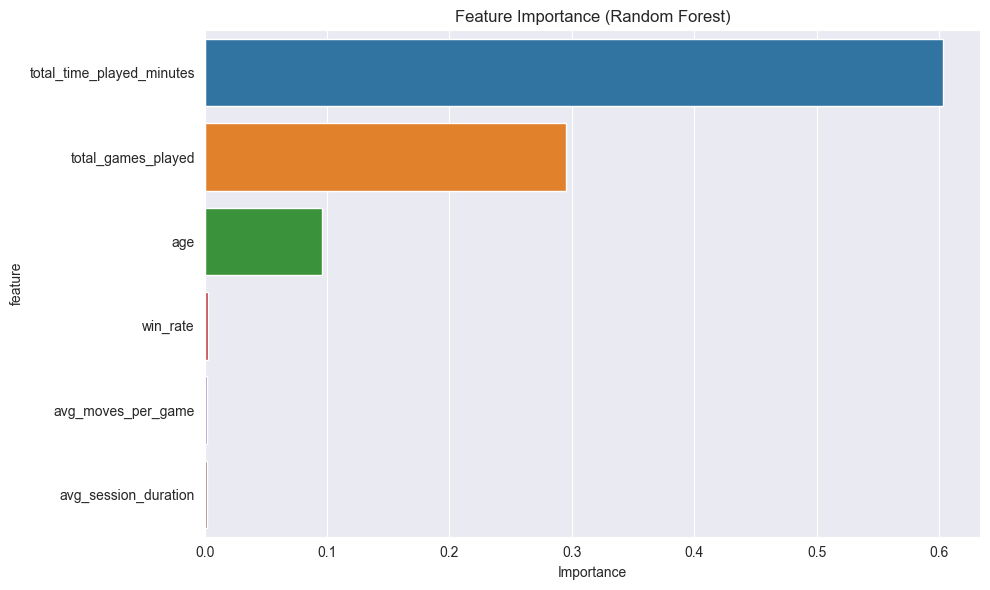

In [13]:
# Feature Importance Plot (using Random Forest)
if 'RandomForest' in best_models:
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_models['RandomForest'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [14]:
# # Save best model and scaler
best_model_name = max(results.items(), key=lambda x: x[1]['R2 Score'])[0]
with open('engagement_model.pkl', 'wb') as f:
    pickle.dump(best_models[best_model_name], f)
with open('engagement_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [15]:
# Print cross-validation scores for best model
cv_scores = cross_val_score(
    best_models[best_model_name], 
    X_train_scaled, 
    y_train, 
    cv=5, 
    scoring='r2'
)

print(f"\nCross-Validation Scores for {best_model_name}:")
print(f"Mean R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-Validation Scores for RandomForest:
Mean R² Score: 0.9871 (+/- 0.0092)


In [16]:
print(best_model)

RandomForest
